In [2]:
"""Utility functions for the HPA Cell Segmentation package."""
import os.path
import urllib
import zipfile

import numpy as np
import scipy.ndimage as ndi
from PIL import Image
from skimage import filters, measure, segmentation
from skimage.morphology import (binary_erosion, closing, disk,
                                remove_small_holes, remove_small_objects, binary_dilation)
from matplotlib import pyplot as plt


In [3]:
a = np.load("r07c18f08p01--cell_mask_2.npy")
print(a.shape)
print(np.unique(a))

(250, 250)
[False  True]


4


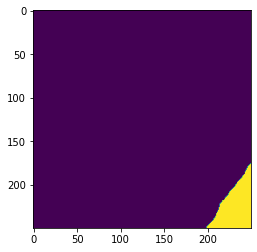

In [8]:
mask = np.load("r07c18f08p01--cell_mask_2.npy")
#mask = np.array(mask > 0).astype(np.uint8)
labeled, num_features = ndi.label(mask)
print(num_features)
plt.imshow(labeled==4)
plt.show()


In [15]:
print(mask.shape)
m = np.expand_dims(mask, 0).transpose((1,2,0)).astype(np.uint8)
m = np.repeat(m, 5, axis=2)
print(m.shape)
m = cv2.resize(m, (256, 256), interpolation=cv2.INTER_LINEAR)
print(m .shape)


(250, 250)
(250, 250, 5)
(256, 256, 5)


In [19]:
m = np.repeat(mask, 5, axis=0)
print(m.sh)

(5, 250, 250)


In [89]:
HIGH_THRESHOLD = 0.4
LOW_THRESHOLD = HIGH_THRESHOLD - 0.25

In [52]:
def __fill_holes(image):
    """Fill_holes for labelled image, with a unique number."""
    boundaries = segmentation.find_boundaries(image)
    image = np.multiply(image, np.invert(boundaries))
    image = ndi.binary_fill_holes(image > 0)
    image = ndi.label(image)[0]
    return image

In [87]:
def label_nuclei(nuclei_pred):
    """Return the labeled nuclei mask data array.

    This function works best for Human Protein Atlas cell images with
    predictions from the CellSegmentator class.

    Keyword arguments:
    nuclei_pred -- a 3D numpy array of a prediction from a nuclei image.

    Returns:
    nuclei-label -- An array with unique numbers for each found nuclei
                    in the nuclei_pred. A value of 0 in the array is
                    considered background, and the values 1-n is the
                    areas of the cells 1-n.
    """
    img_copy = np.copy(nuclei_pred[..., 2])
    borders = (nuclei_pred[..., 1] > 0.05).astype(np.uint8)
    m = img_copy * (1 - borders)

    img_copy[m <= LOW_THRESHOLD] = 0
    img_copy[m > LOW_THRESHOLD] = 1
    img_copy = img_copy.astype(np.bool)
    img_copy = binary_erosion(img_copy)
    # TODO: Add parameter for remove small object size for
    #       differently scaled images.
    # img_copy = remove_small_objects(img_copy, 500)
    img_copy = img_copy.astype(np.uint8)
    markers = measure.label(img_copy).astype(np.uint32)

    mask_img = np.copy(nuclei_pred[..., 2])
    mask_img[mask_img <= HIGH_THRESHOLD] = 0
    mask_img[mask_img > HIGH_THRESHOLD] = 1
    mask_img = mask_img.astype(np.bool)
    mask_img = remove_small_holes(mask_img, 1000)
    # TODO: Figure out good value for remove small objects.
    # mask_img = remove_small_objects(mask_img, 8)
    mask_img = mask_img.astype(np.uint8)
    nuclei_label = segmentation.watershed(
        mask_img, markers, mask=mask_img, watershed_line=True
    )
    nuclei_label = remove_small_objects(nuclei_label, 2500)
    nuclei_label = measure.label(nuclei_label)
    return nuclei_label

In [71]:
def label_cell(nuclei_pred, cell_pred):
    """Label the cells and the nuclei.

    Keyword arguments:
    nuclei_pred -- a 3D numpy array of a prediction from a nuclei image.
    cell_pred -- a 3D numpy array of a prediction from a cell image.

    Returns:
    A tuple containing:
    nuclei-label -- A nuclei mask data array.
    cell-label  -- A cell mask data array.

    0's in the data arrays indicate background while a continous
    strech of a specific number indicates the area for a specific
    cell.
    The same value in cell mask and nuclei mask refers to the identical cell.

    NOTE: The nuclei labeling from this function will be sligthly
    different from the values in :func:`label_nuclei` as this version
    will use information from the cell-predictions to make better
    estimates.
    """
    def __wsh(
        mask_img,
        threshold,
        border_img,
        seeds,
        threshold_adjustment=0.35,
        small_object_size_cutoff=10,
    ):
        img_copy = np.copy(mask_img)
        m = seeds * border_img  # * dt
        img_copy[m <= threshold + threshold_adjustment] = 0
        img_copy[m > threshold + threshold_adjustment] = 1
        img_copy = img_copy.astype(np.bool)
        img_copy = remove_small_objects(img_copy, small_object_size_cutoff).astype(
            np.uint8
        )

        mask_img[mask_img <= threshold] = 0
        mask_img[mask_img > threshold] = 1
        mask_img = mask_img.astype(np.bool)
        mask_img = remove_small_holes(mask_img, 1000)
        mask_img = remove_small_objects(mask_img, 8).astype(np.uint8)
        markers = ndi.label(img_copy, output=np.uint32)[0]
        labeled_array = segmentation.watershed(
            mask_img, markers, mask=mask_img, watershed_line=True
        )
        return labeled_array

    nuclei_label = __wsh(
        nuclei_pred[..., 2] / 255.0,
        0.4,
        1 - (nuclei_pred[..., 1] + cell_pred[..., 1]) / 255.0 > 0.05,
        nuclei_pred[..., 2] / 255,
        threshold_adjustment=-0.25,
        small_object_size_cutoff=500,
    )
    # for hpa_image, to remove the small pseduo nuclei
    nuclei_label = remove_small_objects(nuclei_label, 2500)
    nuclei_label = measure.label(nuclei_label)
    # this is to remove the cell borders' signal from cell mask.
    # could use np.logical_and with some revision, to replace this func.
    # Tuned for segmentation hpa images
    threshold_value = max(0.22, filters.threshold_otsu(cell_pred[..., 2] / 255) * 0.5)
    # exclude the green area first
    cell_region = np.multiply(
        cell_pred[..., 2] / 255 > threshold_value,
        np.invert(np.asarray(cell_pred[..., 1] / 255 > 0.05, dtype=np.int8)),
    )
    sk = np.asarray(cell_region, dtype=np.int8)
    distance = np.clip(cell_pred[..., 2], 255 * threshold_value, cell_pred[..., 2])
    cell_label = segmentation.watershed(-distance, nuclei_label, mask=sk)
    cell_label = remove_small_objects(cell_label, 5500).astype(np.uint8)
    selem = disk(6)
    cell_label = closing(cell_label, selem)
    cell_label = __fill_holes(cell_label)
    # this part is to use green channel, and extend cell label to green channel
    # benefit is to exclude cells clear on border but without nucleus
    sk = np.asarray(
        np.add(
            np.asarray(cell_label > 0, dtype=np.int8),
            np.asarray(cell_pred[..., 1] / 255 > 0.05, dtype=np.int8),
        )
        > 0,
        dtype=np.int8,
    )
    cell_label = segmentation.watershed(-distance, cell_label, mask=sk)
    cell_label = __fill_holes(cell_label)
    cell_label = np.asarray(cell_label > 0, dtype=np.uint8)
    cell_label = measure.label(cell_label)
    cell_label = remove_small_objects(cell_label, 5500)
    cell_label = measure.label(cell_label)
    cell_label = np.asarray(cell_label, dtype=np.uint16)
    nuclei_label = np.multiply(cell_label > 0, nuclei_label) > 0
    nuclei_label = measure.label(nuclei_label)
    nuclei_label = remove_small_objects(nuclei_label, 2500)
    nuclei_label = np.multiply(cell_label, nuclei_label > 0)

    return nuclei_label, cell_label

In [20]:
def label_cell2(cell_pred):
    """label cell with only cell predition"""
    cell_pred = cell_pred / cell_pred.max()
    size = cell_pred.shape[0]
    img = cell_pred.copy()
    cell_pred[..., 2] = filters.gaussian(cell_pred[..., 2], sigma=8)
    threshold_value = max(0.22, filters.threshold_otsu(cell_pred[..., 2]))
    threshold_value1 = max(0.6, filters.threshold_otsu(img[..., 2]))
    # exclude the green area first
    cell_region = np.multiply(
        cell_pred[..., 2],
        np.logical_and(
            np.invert(np.asarray(cell_pred[..., 1] > 0.01)),
            cell_pred[..., 2] > threshold_value
        )
    )
    cell_region1 = np.multiply(
        img[..., 2] > threshold_value1,
        np.invert(np.asarray(cell_pred[..., 1] > 0.01)),
    )
    cell_region_eroded = morphology.erosion(
        cell_region1, morphology.square(25))
    cell_region_eroded = np.asarray(cell_region_eroded, dtype=np.uint8)
    cell_region_eroded = ndi.label(cell_region_eroded)[0]
    remove_size_ratio = int((size / 512)**2)
    cell_region_eroded = remove_small_objects(
        cell_region_eroded, 10 * remove_size_ratio)
    cell_region_eroded = np.asarray(cell_region_eroded > 0, dtype=np.uint8)
    distance = np.clip(cell_pred[..., 2], threshold_value, cell_pred[..., 2])
    local_maxi = feature.peak_local_max(
        cell_region_eroded, indices=False, footprint=np.ones((1, 1)))
    markers = ndi.label(local_maxi)[0]
    cell_label = segmentation.watershed(-distance, markers, mask=cell_region)
    cell_label = remove_small_objects(
        cell_label, 1000 * remove_size_ratio).astype(np.uint8)
    selem = disk(6)
    cell_label = closing(cell_label, selem)
    # this part is to use green channel, and extend cell label to green channel
    # benefit is to exclude cells clear on border but without nucleus
    sk = np.logical_or(
            cell_label > 0,
            cell_pred[..., 1] > 0.1,
        )
    sk = np.asarray(sk, dtype=np.uint8)
    cell_label = segmentation.watershed(-sk, cell_label, mask=sk)
    cell_label = __fill_holes(cell_label)
    cell_label = measure.label(cell_label)
    #cell_label = np.asarray(cell_label, dtype=np.uint16)

    return cell_label

In [2]:
#cell_outline = np.repeat(np.expand_dims(np.array(Image.open("cell_outline.png")), axis=2), 3, axis=2)
#nuc_outline = np.repeat(np.expand_dims(np.array(Image.open("nuc_outline.png")), axis=2), 3, axis=2)
cell_outline = np.array(Image.open("cell_outline.png"))
nuc_outline = np.array(Image.open("nuc_outline.png"))
print(np.unique(cell_outline))
print(cell_outline.shape)

[  0 255]
(1080, 1080)


In [217]:
elevation_map = np.array(filters.sobel(cell_outline) > 0, dtype=np.uint8) * 255
print(np.unique(elevation_map))

[  0 255]


In [237]:
nuc_mask = ndi.binary_fill_holes(nuc_outline).astype(np.uint8)
nuc_labels, num_features = ndi.label(nuc_mask)
cell_outline = cell_outline/255 + 1
ws = segmentation.watershed(cell_outline, nuc_labels)


In [208]:
print(np.all(ws==1))

False


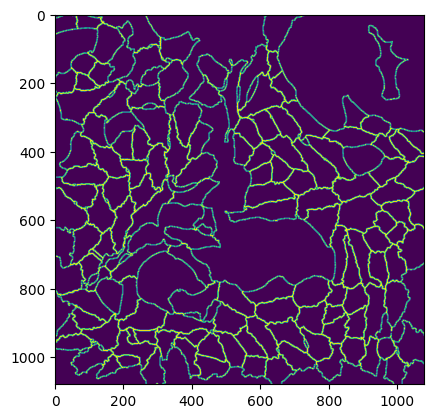

In [218]:
plt.clf()
#nc = np.multiply(nuc_labels, nuc_labels > 0)*255
#nc = cell_outline + nc*255
plt.imshow(elevation_map)
plt.show()

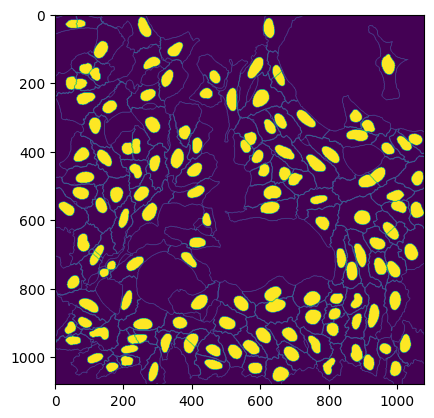

In [258]:
plt.clf()
plt.imshow(nuc_labels)
plt.show()

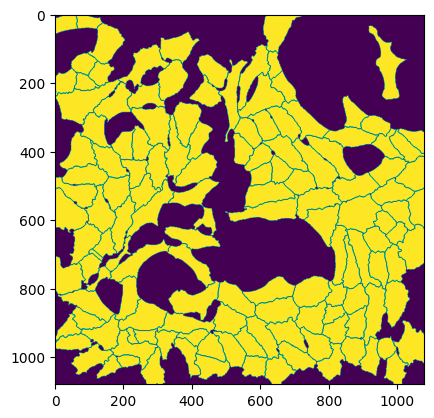

In [9]:
binarized_nu = ndi.binary_fill_holes(nuc_outline).astype('int')
nuc_labels, num_features = ndi.label(binarized_nu)
nuc_labels[nuc_labels > 0] + 1
#nuc_labels[binarized_nu > 0] = 2 # Foreground
nuc_labels[cell_outline > 0] = 1 # background
binarized_cell = segmentation.watershed(cell_outline, nuc_labels)
plt.imshow(binarized_cell > 1)
plt.show()

In [4]:
print(np.unique(binarized_cell))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123]
